# The Goal here is to Learn to Separate Audio in a Efficient Way

In [1]:
import warnings

warnings.filterwarnings('ignore')

In [2]:
#Imports
import math
import librosa
import librosa.display
import IPython.display as ipd
import numpy as np

import pyAudioAnalysis
import pydub
import ffmpeg

import os

import matplotlib.pyplot as plt
from numpy import sin, cos, pi, linspace, arange, log10, absolute, where
from numpy.random import randn
from scipy.signal import lfilter, lfilter_zi, filtfilt, butter, freqz, welch
from scipy.io.wavfile import read , write
from scipy.signal import spectrogram
from matplotlib import pyplot
from matplotlib.pyplot import ylabel, xlabel
from matplotlib.pyplot import plot, legend, show, grid, figure, savefig#, hold

In [18]:
filename = 'audio/training/J_casa_01.wav'

fs, audio1 = read(filename)
f,t,S1 = spectrogram(audio1, fs, window='flattop', nperseg=fs//10, noverlap=fs//20, scaling='spectrum', mode='magnitude')
print('filename: ', filename)
print('Data Length (s): ',t[-1])
print('Sampling frequency (samples/s): ', fs)

#Playing Audio (Reproduce Audio)
ipd.Audio(filename)

C:\Users\lemos\AppData\Local\Temp/ipykernel_6900/391712310.py:3: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, audio1 = read(filename)


filename:  audio/training/J_casa_01.wav
Data Length (s):  6.15
Sampling frequency (samples/s):  44100


C:\Users\lemos\AppData\Local\Temp/ipykernel_6900/3623348973.py:3: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  pyplot.pcolormesh(t, f[:450], S1[:450][:])


Text(0, 0.5, 'frequency(Hz)')

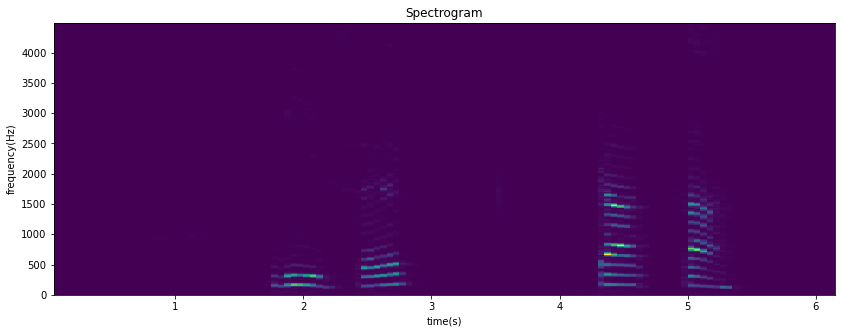

In [19]:
#Spectogram
pyplot.rcParams['figure.figsize'] = 14,5
pyplot.pcolormesh(t, f[:450], S1[:450][:])
pyplot.title("Spectrogram")
xlabel('time(s)')
ylabel('frequency(Hz)')
#show()

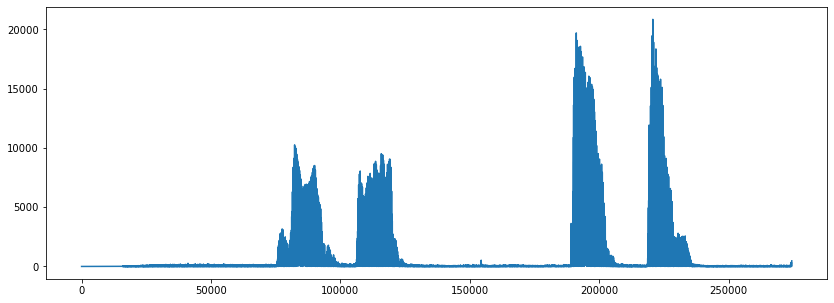

In [23]:
#Filtro ButterWord
wn = 1500/(fs/2)
b3,a3 = butter(4, wn)
audio1_filt = lfilter(b3,a3,audio1)
plot(abs(audio1_filt))

C:\Users\lemos\AppData\Local\Temp/ipykernel_12524/2495383287.py:3: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, audio1 = read(filename)


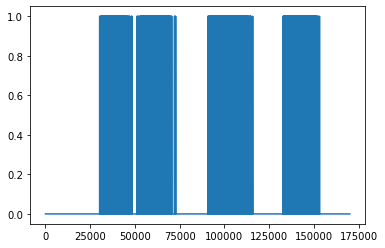

In [7]:
filename = 'C:/Users/lemos/PDS/TP/audio/training/A_lata_01.wav'

fs, audio1 = read(filename)
f,t,S1 = spectrogram(audio1, fs, window='flattop', nperseg=fs//10, noverlap=fs//20, scaling='spectrum', mode='magnitude')

wn = 1500/(fs/2)
b3,a3 = butter(4, wn)
audio1_filt = lfilter(b3,a3,audio1)
#plot(audio1_filt)

#results = [1 if item > 0.001*1e8 else 0 for item in audio1_filt**2]
results = [1 if item > 500 else 0 for item in audio1_filt]
plot(results)
#Playing Audio (Reproduce Audio)
ipd.Audio(filename)

# of chunks detected: 1
C:/Users/lemos/PDS/TP/audio/PD_data/J_chave_02_1.wav
26020 58976
32956


ValueError: rate must be specified when data is a numpy array or list of audio samples.

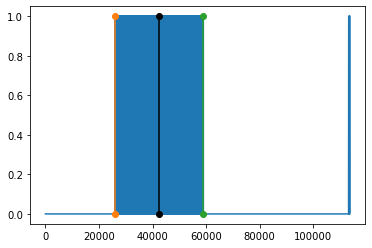

In [47]:
import numpy

# Variables
x1 = x2 = 0
flag = False
chunks = []
coordinates = []
zeros_list = []
silence_len = 2000
min_len = 2000

plot(results)
for i, result in enumerate(results):
    # First signal rise
    if(flag == False and result == 1 and x1 == 0):
        flag = True
        x1 = i
    # Check if fall is permanent
    if(flag == True):
        if(result == 0):
            zeros_list.append(result)
        else:
            zeros_list = []
    # Signal fall
    if(flag == True and len(zeros_list) >= silence_len and x2 == 0):
        flag = False
        x2 = i - len(zeros_list)
        # If data is valid, save it in list
        if(not x2-x1 <= min_len):
            chunks.append(results[x1:x2+1])
            coordinates.append([x1, x2])
            plot([x1, x1], [0, 1], [x2, x2], [0, 1], marker='o')
        # Reset to initial state
        x1 = x2 = 0

print(f'# of chunks detected: {len(chunks)}')

pt1 = coordinates[0]
try:
    pt2 = coordinates[1]
    div_ptn = ((pt2[0] - pt1[1]) / 2) + pt1[1]
except:
    div_ptn = ((pt1[1] + pt1[0]) / 2)
    print(filename)
    errors += 1
# Draw dividing line
plot([div_ptn, div_ptn], [0, 1], marker='o', color="black")
print(pt1[0], pt1[1])
print(pt1[1] - pt1[0])

# Second Possibility (Loop)

In [2]:
filename = 'audio/training2/J_cata_02.wav'

#List of Words
words = ["_chata_0","_chapa_0","_chave_0","_lata_0","_lapa_0","_lava_0","_casa_0","_capa_0","_cave_0","_cata_0","_chuta_0","_chupa_0","_chuva_0","_farta_0","_farpa_0","_farda_0","_ripa_0","_rita_0","_rica_0"]

#List of Dataset Audio versions
d = {"one": 1, "two": 2} #, "three": 3
iterable = d.keys()

#List of people
p = ['A','J','N']

#If you want to change Directory
#os.chdir(r'pythonProject\commonModule\')



# PITCH OR WORD SEGMENTATION ANALYSIS

## This algorithm analyses and segmentate all data with two configurations 
### (Pitch ID/Word ID) -> Purpose
### (Save Segmentation Pictures / Save Segmentated Audio) -> Process_Select

In [5]:
segments = []
errors = 0

Process_Select = False # False for audio save / True for picture save
purpose = True # False for Pitch Segmentation / True for Word Segmentation

for y in words:
    for item in iterable:
        for x in p:
            check = x # For Validation

            # Write file path
            l = str(d[item])
            
            if(purpose == False):
                filename = 'audio/training/'+x+y+l+'.wav' #for Test DataSet
            elif(purpose == True):
                filename = 'audio/PD_data/'+x+y+l+'_1.wav' #for Training DataSet

            # Read file path
            fs, audio1 = read(filename)
            f,t,S1 = spectrogram(audio1, fs, window='flattop', nperseg=fs//10, noverlap=fs//20, scaling='spectrum', mode='magnitude')

            # Apply butterworth Filter
            wn = 1500/(fs/2)
            b3,a3 = butter(4, wn)
            audio1_filt = lfilter(b3,a3,audio1)
            
            # Calculate Results
            if(purpose == False):
                #Pitch Segmentation
                results = [1 if item > 500 else 0 for item in audio1_filt] #350
                silence_len = 10000 #9000
                min_len = 10000 #2000
            elif(purpose == True):
                #Word Segmentation
                results = [1 if item > 0.001*1e8 else 0 for item in audio1_filt**2]
                silence_len = 2000
                min_len = 5000
            
            # Variables
            x1 = x2 = 0
            flag = False
            coordinates = []
            zeros_list = []
            
            plot(results)
            for i, result in enumerate(results):
                # First signal rise
                if(flag == False and result == 1 and x1 == 0):
                    flag = True
                    x1 = i
                # Check if fall is permanent
                if(flag == True):
                    if(result == 0):
                        zeros_list.append(result)
                    else:
                        zeros_list = []
                # Signal fall
                if(flag == True and len(zeros_list) >= silence_len and x2 == 0):
                    flag = False
                    x2 = i - len(zeros_list)
                    # If data is valid, save it in list
                    if(not x2-x1 <= min_len):
                        coordinates.append([x1, x2])
                        plot([x1, x1], [0, 1], [x2, x2], [0, 1], marker='o')
                    # Reset to initial state
                    x1 = x2 = 0         
            
            pt1 = coordinates[0]
            try:
                pt2 = coordinates[1]
                div_ptn = ((pt2[0] - pt1[1]) / 2) + pt1[1]
                #print(filename)
            except:
                div_ptn = ((pt1[0] + pt1[1]) / 2)
                print(f'Error: {filename}')
                errors += 1
            # Draw dividing line
            plot([div_ptn, div_ptn], [0, 1], marker='o', color="black")
                
            
                            
            if (Process_Select == True):
                if(purpose == False):
                    #Save Graphic Ilustration
                    plt.savefig('Pitch Detection/crop_pics/'+x+y+l+'.jpeg')
                elif(purpose == True):
                    #Save Graphic Ilustration
                    plt.savefig('Word Detection/crop_pics/'+x+y+l+'.jpeg')

            elif(Process_Select == False):
                #Make segmentation point integer
                div_ptn = round(div_ptn)
                
                # Fix-sized segmentation (breaks a signal into non-overlapping segments)
                signal = audio1 / (2**15)
                signal_len = len(signal)
                segment_size_t = 1 # segment size in seconds
                segment_size = segment_size_t * fs  # segment size in samples

                # Break signal into list of segments in a single-line Python code
                segment1 = audio1[:div_ptn]
                segment2 = audio1[div_ptn:]
                segments = [segment1, segment2]
                
                

                # Find out the number of Segments
                n = len(segments)


                # Process each chunk with your parameters
                # Save each segment in a seperate filename
                if(purpose == False):
                    for iS, s in enumerate(segments):
                        write('audio/PD_data/'+x+y+l+'_{0:d}.wav'.format(segment_size_t * iS, segment_size_t * (iS + 1)), fs, (s))
                elif(purpose == True ):
                    for iS, s in enumerate(segments):
                        write('audio/WD_data/'+x+y+l+'_{0:d}.wav'.format(segment_size_t * iS, segment_size_t * (iS + 1)), fs, (s))
                    
            #Clean the graphics
            plt.close()
            plt.cla()
            plt.clf()
                    

print(f'# of errors: {errors}')

C:\Users\lemos\AppData\Local\Temp/ipykernel_12524/1472480411.py:22: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, audio1 = read(filename)


Error: audio/PD_data/J_chave_01_1.wav
Error: audio/PD_data/N_chave_01_1.wav
Error: audio/PD_data/J_chave_02_1.wav
Error: audio/PD_data/J_lapa_01_1.wav
Error: audio/PD_data/J_lava_01_1.wav
Error: audio/PD_data/J_lava_02_1.wav
Error: audio/PD_data/J_capa_01_1.wav
Error: audio/PD_data/A_capa_02_1.wav
Error: audio/PD_data/J_capa_02_1.wav
Error: audio/PD_data/J_cave_01_1.wav
Error: audio/PD_data/N_cave_01_1.wav
Error: audio/PD_data/J_cave_02_1.wav
Error: audio/PD_data/A_cata_01_1.wav
Error: audio/PD_data/J_cata_01_1.wav
Error: audio/PD_data/J_cata_02_1.wav
Error: audio/PD_data/J_chuva_01_1.wav
Error: audio/PD_data/J_chuva_02_1.wav
Error: audio/PD_data/A_farta_01_1.wav
Error: audio/PD_data/J_farta_01_1.wav
Error: audio/PD_data/A_farta_02_1.wav
Error: audio/PD_data/J_farta_02_1.wav
Error: audio/PD_data/A_farda_01_1.wav
Error: audio/PD_data/J_farda_01_1.wav
Error: audio/PD_data/A_farda_02_1.wav
Error: audio/PD_data/J_farda_02_1.wav
Error: audio/PD_data/N_farda_02_1.wav
Error: audio/PD_data/J_r

<Figure size 432x288 with 0 Axes>

# Power Spectrum Analysis

Save all spectograms into a folder

In [ ]:
for y in words:
    for item in iterable:      
        for x in p:
            check = x #For Validation

            #Write file path
            l = str(d[item])

            filename = 'audio/training2/'+x+y+l+'.wav' #for Training DataSet
            #filename = 'audio/test/'+x+y+l+'.wav' #for Test DataSet


            #Read file path
            fs, audio1 = read(filename)
            f,t,S1 = spectrogram(audio1, fs, window='flattop', nperseg=fs//10, noverlap=fs//20, scaling='spectrum', mode='magnitude')

            #Spectogram
            pyplot.rcParams['figure.figsize'] = 14,5
            pyplot.pcolormesh(t, f[:450], S1[:450][:])
            pyplot.title("Spectrogram")
            xlabel('time(s)')
            ylabel('frequency(Hz)')
            plt.savefig('Word Detection/spect_pics/'+x+y+l+'.jpeg')
            plt.close()
            plt.cla()
            plt.clf()
            






